In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengersDF
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoMLP
from neuralforecast.models import NBEATS, NHITS
from ray import tune

import warnings
warnings.filterwarnings("ignore")

# data

In [2]:
Y_df = AirPassengersDF
Y_df = Y_df.reset_index(drop = True)
print(Y_df.head)
print()
print(Y_df.shape)
print()
print(Y_df["unique_id"].value_counts())

<bound method NDFrame.head of      unique_id         ds      y
0          1.0 1949-01-31  112.0
1          1.0 1949-02-28  118.0
2          1.0 1949-03-31  132.0
3          1.0 1949-04-30  129.0
4          1.0 1949-05-31  121.0
..         ...        ...    ...
139        1.0 1960-08-31  606.0
140        1.0 1960-09-30  508.0
141        1.0 1960-10-31  461.0
142        1.0 1960-11-30  390.0
143        1.0 1960-12-31  432.0

[144 rows x 3 columns]>

(144, 3)

1.0    144
Name: unique_id, dtype: int64


# model

In [8]:
horizon = 12
models = [
    NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
    NHITS(input_size=2 * horizon, h=horizon, max_steps=50),
    # Ray tune explore config
    AutoMLP(
        config = dict(
            max_steps = 100, # Operates with steps not epochs
            input_size = tune.choice([3 * horizon]),
            learning_rate = tune.choice([1e-3])
        ),
        h = horizon,
        num_samples = 1, 
        cpus = 1
    )
]
nf = NeuralForecast(models = models, freq = "M")
nf.fit(df = Y_df)

2024-11-07 22:48:38,215	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Administrator/ray_results/_train_tune_2024-11-07_22-48-31' in 0.0067s.
Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | mlp  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.


# model predicting

In [9]:
Y_hat_df = nf.predict().reset_index()
Y_hat_df

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,unique_id,ds,NBEATS,NHITS,AutoMLP
0,1.0,1961-01-31,444.368103,450.529510,454.914154
1,1.0,1961-02-28,464.821472,468.269562,430.188354
2,1.0,1961-03-31,472.306366,478.337708,458.478607
3,1.0,1961-04-30,493.174072,509.043457,477.244476
4,1.0,1961-05-31,531.443726,562.544495,522.253052
5,1.0,1961-06-30,621.822571,595.196106,608.805603
6,1.0,1961-07-31,678.368225,658.282471,694.153198
7,1.0,1961-08-31,668.124023,658.865540,689.863464
8,1.0,1961-09-30,585.601257,598.597290,583.123596
9,1.0,1961-10-31,506.837067,565.858276,511.057098


<Figure size 1200x300 with 0 Axes>

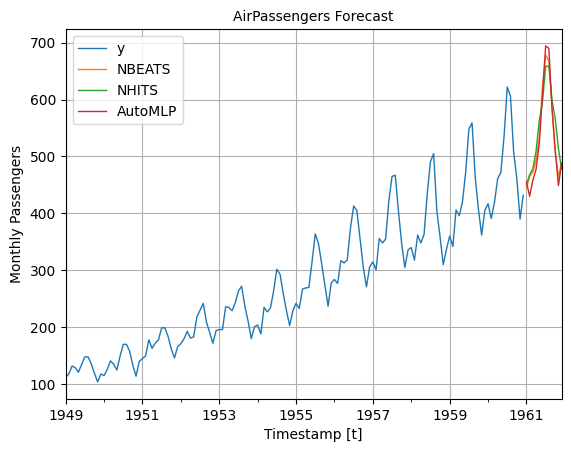

In [23]:
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds')

plt.figure(figsize = (12, 3))
plot_df[['y', 'NBEATS', 'NHITS', 'AutoMLP']].plot(linewidth=1.0)
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.axvline(x = plot_df.index[-horizon], color='k', linestyle='--', linewidth=2)
plt.legend(prop={'size': 10})
plt.grid()

# model save

In [26]:
nf.save(
    path = "./checkpoints/test_run/",
    model_index = None,
    overwrite = True,
    save_dataset = True,
)

# model load

In [27]:
nf2 = NeuralForecast.load(path = "./checkpoints/test_run/")
Y_hat_df = nf2.predict().reset_index()
Y_hat_df

Global seed set to 1
Global seed set to 1
Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,unique_id,ds,AutoMLP,NBEATS,NHITS
0,1.0,1961-01-31,454.914154,444.368103,450.529510
1,1.0,1961-02-28,430.188354,464.821472,468.269562
2,1.0,1961-03-31,458.478607,472.306366,478.337708
3,1.0,1961-04-30,477.244476,493.174072,509.043457
4,1.0,1961-05-31,522.253052,531.443726,562.544495
5,1.0,1961-06-30,608.805603,621.822571,595.196106
6,1.0,1961-07-31,694.153198,678.368225,658.282471
7,1.0,1961-08-31,689.863464,668.124023,658.865540
8,1.0,1961-09-30,583.123596,585.601257,598.597290
9,1.0,1961-10-31,511.057098,506.837067,565.858276


# result

<Figure size 1200x300 with 0 Axes>

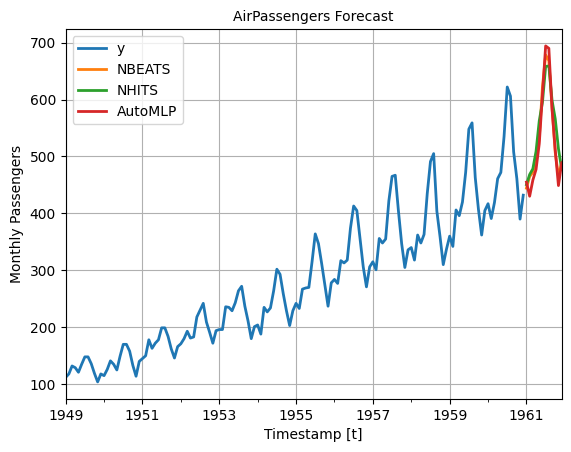

In [30]:
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes

plt.figure(figsize = (12, 3))
plot_df[['y', 'NBEATS', 'NHITS', 'AutoMLP']].plot(linewidth=2)
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.axvline(x=plot_df.index[-horizon], color='k', linestyle='--', linewidth=2)
plt.legend(prop={'size': 10})
plt.grid()